## Fraud detection via Kmeans

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy  as np
import seaborn as sns

from pathlib                 import Path
from sklearn.preprocessing   import MinMaxScaler
from sklearn.cluster         import MiniBatchKMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics         import roc_auc_score, confusion_matrix

In [4]:
# set root directory
path_root = Path("C:/Users/giann/data-science-core")
os.chdir(path_root)
print(f'- Root directory = {os.getcwd()}')

- Root directory = C:\Users\giann\data-science-core


### Load data

In [6]:
path_dataset = path_root / 'dataset/banksim.csv'
data         = pd.read_csv(path_dataset, index_col = 0) 
movements    = data.values
data.head()

,age,gender,category,amount,fraud
171915,3,F,es_transportation,49.71,0
426989,4,F,es_health,39.29,0
310539,3,F,es_transportation,18.76,0
215216,4,M,es_transportation,13.95,0
569244,2,M,es_transportation,49.87,0


### EDA

In [8]:
# check where it occurs more fraud
print(data.groupby('category').mean())

                           amount     fraud
category                                   
es_barsandrestaurants   43.841793  0.022472
es_contents             55.170000  0.000000
es_fashion              59.780769  0.020619
es_food                 35.216050  0.000000
es_health              126.604704  0.242798
es_home                120.688317  0.208333
es_hotelservices       172.756245  0.548387
es_hyper                46.788180  0.125000
es_leisure             229.757600  1.000000
es_otherservices       149.648960  0.600000
es_sportsandtoys       157.251737  0.657895
es_tech                132.852862  0.179487
es_transportation       27.422014  0.000000
es_travel              231.818656  0.944444
es_wellnessandbeauty    66.167078  0.060606


In [10]:
# Count the values of the observations in each age group
# it does not make sense categorize per age becuase they are similar
print(data['age'].value_counts())

2    2333
3    1718
4    1279
5     792
1     713
6     314
0      40
U      11
Name: age, dtype: int64


### Spot abnormality

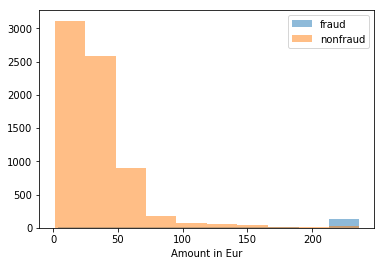

In [12]:
df_fraud     = data.loc[data.fraud == 1] 
df_non_fraud = data.loc[data.fraud == 0]

# Plot histograms of the amounts in fraud and non-fraud data 
plt.hist(df_fraud.amount    , alpha=0.5, label='fraud')
plt.hist(df_non_fraud.amount, alpha=0.5, label='nonfraud')
plt.xlabel('Amount in Eur')
plt.legend()
plt.show()

## Cluster with K-mean 

In [22]:
# load data
path_dataset = path_root / 'dataset/banksim_adj.csv'
data = pd.read_csv(path_dataset, index_col = 0)
data.head()

,age,amount,fraud,M,es_barsandrestaurants,es_contents,es_fashion,es_food,es_health,es_home,es_hotelservices,es_hyper,es_leisure,es_otherservices,es_sportsandtoys,es_tech,es_transportation,es_travel
0,3,49.71,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,4,39.29,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,3,18.76,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,4,13.95,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,2,49.87,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0


`banksim_adj.csv` has been obtained using `pd.get_dummies(data, prefix_sep='_', drop_first = True, columns = ['category'])` from `banksim.csv`

In [29]:
# Define the scaler and apply to the data
scaler   = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
clustno  = range(1, 10)

(7189, 17)

In [25]:
# Run MiniBatch Kmeans over the number of clusters
kmeans = [MiniBatchKMeans(n_clusters=i) for i in clustno]
# Obtain the score for each model
score = [kmeans[i].fit(X_scaled).score(X_scaled) for i in range(len(kmeans))]

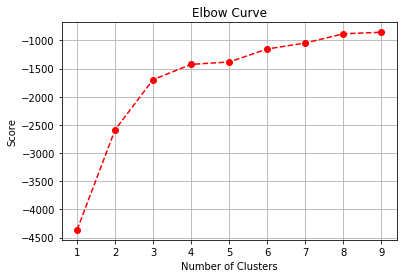

In [27]:
# Plot the models and their respective score 
plt.plot(clustno, score, 'ro--')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.grid()
plt.show()

### Detect outliers 

In [30]:
# Split the data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=0)
# Define K-means model 
kmeans = MiniBatchKMeans(n_clusters = 3, random_state = 42).fit(X_train)

In [31]:
# Obtain predictions and calculate distance from cluster centroid
X_test_clusters = kmeans.predict(X_test)
X_test_clusters_centers = kmeans.cluster_centers_
dist = [np.linalg.norm(x-y) for x, y in zip(X_test, X_test_clusters_centers[X_test_clusters])]

In [32]:
# Create fraud predictions based on outliers on clusters 
# the top 5% of data will be detected as anomolous sample 
km_y_pred = np.array(dist)
km_y_pred[dist >= np.percentile(dist, 95)] = 1
km_y_pred[dist < np.percentile(dist,  95)] = 0

### Model Validation
Can be adjusted by changing the percentile

0.8109115999408585


Text(91.68, 0.5, 'True Value')

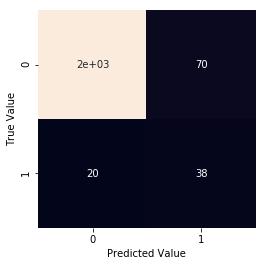

In [33]:
# Obtain the ROC score
print(roc_auc_score(y_test, km_y_pred))

# Create a confusion matrix
km_cm = confusion_matrix(y_test, km_y_pred)
sns.heatmap(km_cm, square = True, annot = True, cbar = False)
plt.xlabel('Predicted Value')
plt.ylabel('True Value')